# Multi-layer Perceptron Example

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
print ("CURRENT TF VERSION IS [%s]" % (tf.__version__))
print ("PACKAGES LOADED")

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

CURRENT TF VERSION IS [1.3.1]
PACKAGES LOADED


## LOAD

In [3]:
# LOAD DATA
cwd = os.getcwd()
loadpath = cwd + "/data/custom_data.npz"
l = np.load(loadpath)
print (l.files)

# PARSE LOADED DATA
trainimg   = l['trainimg']
trainlabel = l['trainlabel']
testimg    = l['testimg']
testlabel  = l['testlabel']
imgsize    = l['imgsize']
categories = l['categories']
use_gray   = l['use_gray']
ntrain = trainimg.shape[0]
nclass = trainlabel.shape[1]
dim    = trainimg.shape[1]
ntest  = testimg.shape[0]
print ("%d TRAIN IMAGES" % (ntrain))
print ("%d TEST IMAGES" % (ntest))
print ("%d DIMENSIONAL INPUT" % (dim))
print ("%d CLASSES" % (nclass))
print (imgsize)
print (categories)

['trainlabel', 'imgsize', 'trainimg', 'testimg', 'testlabel', 'use_gray', 'categories']
992 TRAIN IMAGES
249 TEST IMAGES
4096 DIMENSIONAL INPUT
5 CLASSES
[64 64]
['al_gore' 'MS' 'liv_tyler' 'Mrs_obama' 'Apple']


## DEFINE MODEL

In [4]:
# NETWORK TOPOLOGIES
n_input    = dim
n_hidden_1 = 256 
n_hidden_2 = 128 
n_classes  = nclass  

# INPUTS AND OUTPUTS
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])
    
# NETWORK PARAMETERS
stddev = 0.1
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1], stddev=stddev)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], stddev=stddev)),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes], stddev=stddev))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}
print ("NETWORK READY")

NETWORK READY


## DEFINE GRAPH

In [5]:
# MODEL
def multilayer_perceptron(_X, _weights, _biases):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(_X, _weights['h1']), _biases['b1'])) 
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, _weights['h2']), _biases['b2']))
    return (tf.matmul(layer_2, _weights['out']) + _biases['out'])

# PREDICTION
pred = multilayer_perceptron(x, weights, biases)

# LOSS AND OPTIMIZER
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred))
optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost) 
corr = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

# INITIALIZER
init = tf.global_variables_initializer()
print ("FUNCTIONS READY")

FUNCTIONS READY


## RUN

Epoch: 010/010 cost: 0.955557254
 TRAIN ACCURACY: 0.630
 TEST ACCURACY: 0.643
 89 MISSED


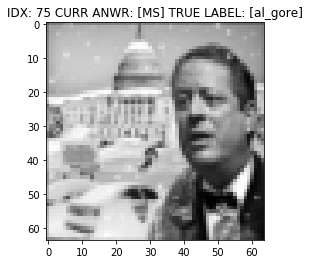

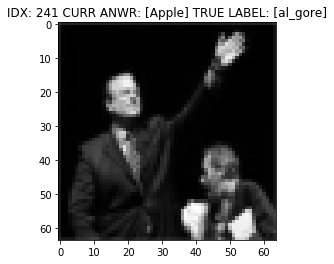

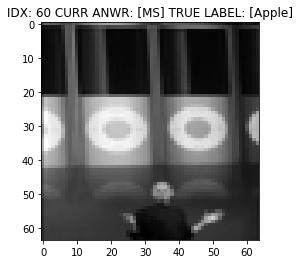

OPTIMIZATION FINISHED


In [8]:
# PARAMETERS
training_epochs = 50
batch_size      = 100
disp_each       = 10
plot_each       = 10
# LAUNCH THE GRAPH
sess = tf.Session()
sess.run(init)
# OPTIMIZE
for epoch in range(training_epochs):
    total_batch = int(ntrain/batch_size)
    randpermlist = np.random.permutation(ntrain)
    sun_cost = 0.
    for i in range(total_batch):
        randidx  = randpermlist[i*batch_size:min((i+1)*batch_size, ntrain-1)]
        batch_xs = trainimg[randidx, :]
        batch_ys = trainlabel[randidx, :]                
        feeds = {x: batch_xs, y: batch_ys}
        sess.run(optm, feed_dict=feeds)
        sun_cost += sess.run(cost, feed_dict=feeds)
    avg_cost = sun_cost / total_batch
        
    # DISPLAY
    if (epoch+1) % disp_each == 0 or epoch == training_epochs-1:
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch+1, training_epochs, avg_cost))
        feeds = {x: batch_xs, y: batch_ys}
        train_acc = sess.run(accr, feed_dict=feeds)
        print (" TRAIN ACCURACY: %.3f" % (train_acc))
        feeds = {x: testimg, y: testlabel}
        test_acc = sess.run(accr, feed_dict=feeds)
        print (" TEST ACCURACY: %.3f" % (test_acc))
        
    # PLOT
    if (epoch+1) % plot_each == 0 or epoch == training_epochs-1:
        ntemp = int(ntest/batch_size) + 1 
        missidxlist = []
        for ii in range(ntemp):
            iii = np.arange(ii*batch_size, min(ntest, (ii+1)*batch_size))
            feeds = {x: testimg[iii, :], y: testlabel[iii, :]}
            missidx = np.where(sess.run(corr, feed_dict=feeds) == 0)[0]
            missidxlist = np.concatenate((missidxlist, iii[missidx]))
        nmiss = len(missidxlist)
        print (" %d MISSED" % (nmiss))
        # PLOT MISSCLASSIFIED (UPTO THREE)
        missidxlist = np.random.permutation(missidxlist.astype(int))
        selmissidx  = missidxlist[:min(3, nmiss)].astype(int)
        feeds_miss  = {x: testimg[selmissidx, :], y: testlabel[selmissidx, :]}
        pred_miss   = sess.run(pred, feed_dict=feeds_miss)
        answ_miss   = np.argmax(pred_miss, 1)
        answ_corr   = np.argmax(testlabel[selmissidx, :], 1)
        for idx in range(len(selmissidx)):
            cidx = selmissidx[idx]
            anw  = answ_miss[idx]
            ref  = answ_corr[idx]
            if use_gray != 0:
                currimg = np.reshape(testimg[cidx, :], (imgsize[0], imgsize[1]))
                plt.imshow(currimg, cmap='gray')
            else:
                currimg = np.reshape(testimg[cidx, :], (imgsize[0], imgsize[1], -1))
                plt.imshow(currimg)
            anw_category = categories[anw]
            ref_category = categories[ref]
            title_string = ("IDX: %d CURR ANWR: [%s] TRUE LABEL: [%s]" 
                % (cidx, anw_category, ref_category))
            plt.title(title_string) 
            plt.show() 
print ("OPTIMIZATION FINISHED")